In [1]:
# load example data from github
!git clone https://github.com/match-Aero/bibazu_example_data.git

Cloning into 'bibazu_example_data'...
remote: Enumerating objects: 186, done.
remote: Total 186 (delta 0), reused 0 (delta 0), pack-reused 186
Receiving objects: 100% (186/186), 34.40 MiB | 14.08 MiB/s, done.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tkinter import filedialog as fd
import os

import tensorflow as tf
from tensorflow import keras
from keras import layers

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


In [3]:

%load_ext tensorboard

import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [4]:
#function to plot 9 samples from dataset
def plot_samples(dataset,title):
    plt.figure(figsize=(5, 5))
    plt.suptitle(title)
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(int(np.argmax(labels[i])))
            plt.axis("off")

In [5]:
#standard paths
synthetic_ds_path = "bibazu_example_data/dataset/Rk2i_synthetic/"
real_ds_path = "bibazu_example_data/dataset/Rk2i_real/"

In [6]:
#load images into batched dataset objects

#dataset parameters
img_height = 224
img_width = 224
validation_split = 0.2

train_batch_size = 20
val_batch_size = 5
test_batch_size = 1

#synthetic dataset for training and validation
train_ds = keras.preprocessing.image_dataset_from_directory(
    directory=synthetic_ds_path,
    labels='inferred',
    label_mode='categorical',
    batch_size=train_batch_size,
    validation_split = validation_split,
    subset = 'training',
    seed = 10,
    color_mode = 'rgb',
    #shuffle = False,
    image_size=(img_height, img_width))

val_ds = keras.preprocessing.image_dataset_from_directory(
    directory=synthetic_ds_path,
    labels='inferred',
    label_mode='categorical',
    batch_size=val_batch_size,
    validation_split = validation_split,
    subset = 'validation',
    seed = 10,
    color_mode = 'rgb',
    #shuffle = False,
    image_size=(img_height, img_width))

#real dataset for testing trained model
test_ds = keras.preprocessing.image_dataset_from_directory(
    directory=real_ds_path,
    labels='inferred',
    label_mode='categorical',
    batch_size=test_batch_size,
    color_mode = 'rgb',
    shuffle = False,
    image_size=(img_height, img_width))

#plot_samples(train_ds,"pre-augmentation")

Found 80 files belonging to 4 classes.
Using 64 files for training.
Found 80 files belonging to 4 classes.
Using 16 files for validation.
Found 80 files belonging to 4 classes.


In [7]:
#get number of classes for output layer size
dataset_labels = train_ds.class_names
num_classes = len(dataset_labels)


In [8]:
train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [9]:
#augmentations
#augmentations can also be added as layer to the model, it is then performed by the GPU

#define augmentation set
data_augmentation = keras.Sequential([
        layers.RandomRotation(0.025),
        layers.RandomBrightness(0.4),
        layers.RandomContrast(0.2),
        layers.RandomTranslation(0.1,0.1),
        layers.RandomZoom(0.1)
        ])

#apply augmentation set to training dataset
train_ds_augmentend = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE)

#plot_samples(train_ds_augmentend,"augmented")

In [10]:
normalization_layer = layers.Rescaling(1./255)
train_ds_augmentend = train_ds_augmentend.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

#plot_samples(train_ds_augmentend,"augmented")

In [11]:
#load an empty MobileNet model
model = keras.applications.mobilenet.MobileNet()

#remove last 4 layers (determined in fine tuning)
x = model.layers[-5].output

#set proper size for last layer
x = tf.keras.layers.Reshape(target_shape=(1024,))(x)

#add dense-layer as output
output = tf.keras.layers.Dense(units=num_classes, activation='softmax')(x)

#set input and output layers
model = keras.models.Model(inputs=model.input, outputs=output)

#compile model, set learning parameters
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

17225924/17225924 [==============================] - 0s 0us/step


In [12]:
#training
history = model.fit(x=train_ds_augmentend,
            steps_per_epoch=len(train_ds),
            validation_data=val_ds,
            validation_steps=len(val_ds),
            epochs=200,
            verbose=2
           )
            #tf: 6m 20s  callbacks=[tensorboard_callback]
            #ohnetf: 3m45s


Epoch 1/200
4/4 - 30s - loss: 1.9707 - accuracy: 0.2969 - val_loss: 1.5590 - val_accuracy: 0.1875 - 30s/epoch - 7s/step
Epoch 2/200
4/4 - 1s - loss: 1.7462 - accuracy: 0.3750 - val_loss: 1.5002 - val_accuracy: 0.1875 - 1s/epoch - 253ms/step
Epoch 3/200
4/4 - 1s - loss: 1.7707 - accuracy: 0.2188 - val_loss: 1.4703 - val_accuracy: 0.1875 - 944ms/epoch - 236ms/step
Epoch 4/200
4/4 - 2s - loss: 1.6506 - accuracy: 0.3438 - val_loss: 1.4551 - val_accuracy: 0.1250 - 2s/epoch - 382ms/step
Epoch 5/200
4/4 - 1s - loss: 1.5688 - accuracy: 0.4062 - val_loss: 1.4395 - val_accuracy: 0.1875 - 1s/epoch - 350ms/step
Epoch 6/200
4/4 - 1s - loss: 1.5016 - accuracy: 0.4219 - val_loss: 1.4221 - val_accuracy: 0.1250 - 974ms/epoch - 243ms/step
Epoch 7/200
4/4 - 1s - loss: 1.5087 - accuracy: 0.4219 - val_loss: 1.3844 - val_accuracy: 0.1250 - 935ms/epoch - 234ms/step
Epoch 8/200
4/4 - 1s - loss: 1.3258 - accuracy: 0.4219 - val_loss: 1.3525 - val_accuracy: 0.3125 - 972ms/epoch - 243ms/step
Epoch 9/200
4/4 - 1s 

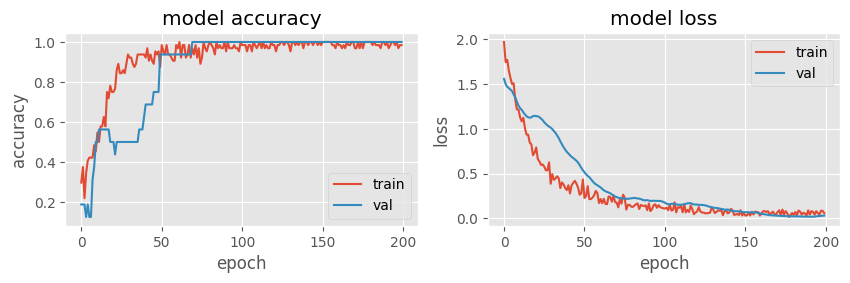

In [13]:
#plot training history
plt.style.use("ggplot")
fig,axs = plt.subplots(1,2)

fig.set_figheight(2.5)
fig.set_figwidth(10)

axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_title('model accuracy')
axs[0].set_ylabel('accuracy')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'val'], loc='lower right')

axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('model loss')
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'val'], loc='upper right')

plt.show()

In [15]:
#save model
model_save_path = "trained_models"

if not model_save_path == "":
    keras.models.save_model(model,model_save_path)
    print("model saved to", model_save_path)

model saved to models


In [ ]:
#load previously trained model
model_load_path = model_save_path

if not model_load_path == "":
    model = keras.models.load_model(model_load_path,compile=False)
    model.compile()

In [19]:
#do prediction on real dataset
prediction_ds = test_ds #dataset to perform prediction on

test_predictions = model.predict(x=prediction_ds, steps=len(prediction_ds), verbose=2)
predicted_labels = test_predictions.argmax(axis=1) #get labes for predictions

#get true labels from real dataset
ds_true_labes = tf.concat([y for x, y in prediction_ds], axis=0)
ds_true_labes = np.argmax(ds_true_labes, axis=1)

80/80 - 1s - 900ms/epoch - 11ms/step


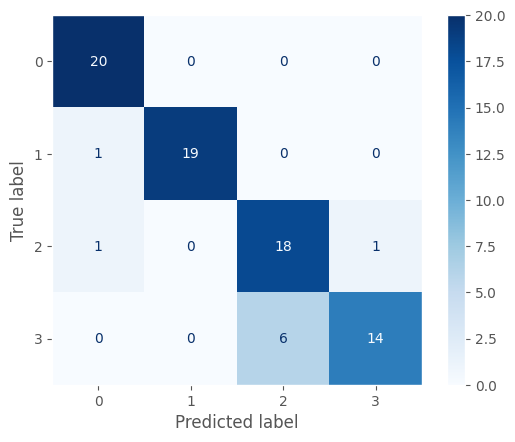

In [20]:
#calculate confusion matrix
cm = confusion_matrix(y_true=ds_true_labes, y_pred=predicted_labels)

#plot confusion matrix
cm_plot = ConfusionMatrixDisplay(confusion_matrix = cm,display_labels = dataset_labels)
cm_plot.plot(cmap= plt.cm.Blues)
plt.grid(None)